# Testing your code
_building confidence that it is doing what it is supposed to!_ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams["font.size"] = 14

## Mathematical identities & analytic solutions
_We know the answer_

For example, for a moving average calculation, we know that if we compute the moving average along a straight line, the average over each segment should be the same as if we evaluate the line at the centre of that segment. 

In [2]:
from agu_oss import moving_average

In [3]:
def line(x, slope=1, intercept=0):
    return slope * x + intercept

In [29]:
window_width = 5
n = 20
x = np.linspace(0, 100, n)
y = line(x)

In [37]:
if np.mod(window_width, 2) == 1:
    moving_average_x = x  
elif np.mod(window_width, 2) == 0: 
    # average assigned at the centers
    moving_average_x = x - np.diff(x[:2])/2 # assumes evenly spaced x

In [38]:
moving_average_y = moving_average(y, window_width)

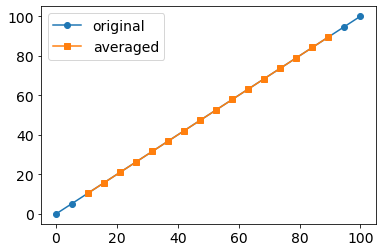

In [39]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, '-o', label="original")
ax.plot(moving_average_x, moving_average_y, '-s', label="averaged")
ax.legend()

In [40]:
y_test = line(moving_average_x)

start_ind = window_width // 2
end_ind = len(y) - (window_width - start_ind)
passed = np.allclose(
    moving_average_y[start_ind:end_ind],
    y_test[start_ind:end_ind]
)
assert(passed)

## Code comparisons
_Compare against an independent implementation_

We can also implement a moving average using pandas. Lets compare with that. 

In [41]:
import pandas as pd

In [42]:
df = pd.DataFrame({
    "x": x,
    "y": y
})
df.set_index("x", inplace=True)

In [43]:
pd_averaged = df["y"].rolling(window=window_width).mean()

In [44]:
pd_averaged

x
0.000000            NaN
5.263158            NaN
10.526316           NaN
15.789474           NaN
21.052632     10.526316
26.315789     15.789474
31.578947     21.052632
36.842105     26.315789
42.105263     31.578947
47.368421     36.842105
52.631579     42.105263
57.894737     47.368421
63.157895     52.631579
68.421053     57.894737
73.684211     63.157895
78.947368     68.421053
84.210526     73.684211
89.473684     78.947368
94.736842     84.210526
100.000000    89.473684
Name: y, dtype: float64

the pandas approach puts the value at the end of the window, whereas our implementation puts it at the center. So we need to account for that in our comparison 

In [57]:
passed_comparison = np.allclose(
    pd_averaged.values[window_width-1:-1],
    moving_average_y[start_ind:end_ind]
)
assert(passed_comparison)
passed_comparison

True

## Checking Behaviour: Convergence 
_We expect certain behaviours of the code_

Even if we don't know the real solution, we know certain things about how the solution to converge.

For example: computing derivatives. Consider the Taylor expansion of a function 

$$
f(x + h) \simeq f(x) + \frac{\partial f(x)}{\partial x} h + \mathcal{O}(h^2)
$$

If we approximate the solution to $f(x + h)$ by $f(x)$, the we expect that as we decrease $h$, then the error $\varepsilon$ should decrease as $\mathcal{O}(h)$:

$$
\varepsilon(h) = |f(x + h) - f(x)|
$$

e.g. for small enough $h$, if we decrease $h$ by a factor of 2, $\varepsilon$ should decrease by a factor of 2. 

If instead, we include gradient information in our approximation of $f(x + h)$, namely using $f(x) + \frac{\partial f(x)}{\partial x} h$, then as we decrease h, the error $\hat{\varepsilon}$ should decrease as $\mathcal{O}(h)$:

$$
\hat{\varepsilon}(h) = \left|f(x + h) - \left(f(x) + \frac{\partial f(x)}{\partial x} h)\right)\right|
$$

e.g. for small enough $h$, if we decrease $h$ by a factor of 2, $\hat{\varepsilon}$ should decrease by a factor of 4. 

#### Why do we care about this behaviour?

If we are using gradient-based optimization (e.g. in an inversion or a machine learning application), we need to provide methods for computing derivatives at any point. This test checks the behaviour of the derivative. 

**For reference:** https://doi.org/10.1137/1.9781611973808

In [66]:
def f(x):
    """
    A decaying sinusoid
    """
    return np.exp(-x**2/10) * np.sin(2*x)

In [67]:
def f_deriv(x):
    """
    The derivative of our decaying sinusoid
    """
    return -x/5 * np.exp(-x**2/10) * np.sin(2*x) + 2*np.exp(-x**2/10) * np.cos(2*x)

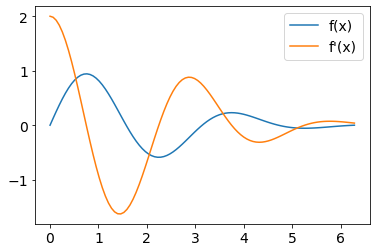

In [80]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(0, 2*np.pi, 100)
ax.plot(x, f(x), label="f(x)")
ax.plot(x, f_deriv(x), label="f'(x)")
ax.legend()

It looks okay (?), how do we test it? 

In [108]:
x = 1
h0 = 0.5
reduce_by = 2
n_iter = 8

# initiate with nans 
err1 = np.nan*np.zeros(n_iter)
err2 = np.nan*np.zeros(n_iter)
order1 = np.nan*np.zeros(n_iter)
order2 = np.nan*np.zeros(n_iter)

# compute function and derivative at x
f_x = f(x)
f_deriv_x = f_deriv(x)

# create our vector of h-values 
h = h0 * (1/reduce_by)**(np.arange(n_iter))

for i, hi in enumerate(h):
    f_true = f(x+hi)
    err1[i] = np.abs(f_true - f_x)
    err2[i] = np.abs(f_true - (f_x + hi*f_deriv_x))
    
    if i > 0: 
        order1[i] = (err1[i-1] / err1[i])/reduce_by
        order2[i] = (err2[i-1] / err2[i])/reduce_by
    
    print(f"{hi:1.2e}  {err1[i]:1.2e}  {order1[i]:1.2f}  {err2[i]:1.2e}  {order2[i]:1.2f}")

5.00e-01  7.10e-01  nan  2.51e-01  nan
2.50e-01  3.11e-01  1.14  8.15e-02  1.54
1.25e-01  1.37e-01  1.13  2.25e-02  1.81
6.25e-02  6.32e-02  1.09  5.87e-03  1.92
3.12e-02  3.02e-02  1.05  1.50e-03  1.96
1.56e-02  1.47e-02  1.03  3.78e-04  1.98
7.81e-03  7.26e-03  1.01  9.48e-05  1.99
3.91e-03  3.61e-03  1.01  2.38e-05  2.00


Text(0, 0.5, 'error')

Substituting symbol O from STIXNonUnicode
Substituting symbol O from STIXNonUnicode
Substituting symbol O from STIXNonUnicode
Substituting symbol O from STIXNonUnicode


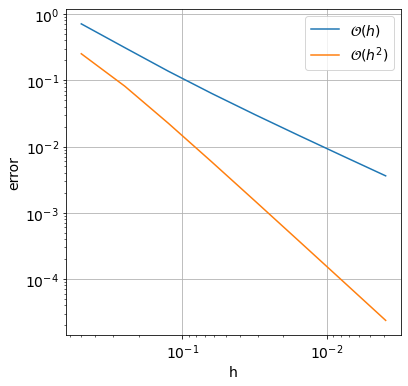

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))


ax.loglog(h, err1, label="$\mathcal{O}(h)$");
ax.loglog(h, err2, label="$\mathcal{O}(h^2)$");
ax.invert_xaxis()
ax.grid("both")
ax.legend()
# ax.set_aspect("equal")

ax.set_xlabel("h")
ax.set_ylabel("error")

## Example as a test
https://arxiv.org/pdf/1508.07231.pdf

## Related: error handling 
_sometimes the coude should "break"_ 